# Import module

In [2]:
import codecs # Word encoding
import glob # regex
import multiprocessing # multithreading
import os
import pprint
import re
import nltk # toeknize sentence
import gensim.models.word2vec as w2v # word2vec
import sklearn.manifold #dimensionality reduction
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns # visualization

In [3]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


# Process the data

In [4]:
nltk.download('punkt') # pretrained tokenizer
nltk.download('stopwords') # remove (and or the a an)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kachunfung/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kachunfung/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
book_filenames = sorted(glob.glob('the_big_short.txt'))
book_filenames

['the_big_short.txt']

In [8]:
#initialize rawunicode
corpus_raw = u""

In [12]:
# read it as utf 8 format, 
# add it to the raw corpus
print("Reading '{0}'...".format(book_filename))
with codecs.open(book_filename, "r", "utf-8") as book_file:
    corpus_raw += book_file.read()
print("Corpus is now {0} characters long".format(len(corpus_raw)))

Reading 'the_big_short.txt'...
Corpus is now 1613808 characters long


# 1. Tokenize every single word

In [13]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [14]:
raw_sentences = tokenizer.tokenize(corpus_raw)

Clean the sentence and split it to word

In [15]:
#remove symbols and split word
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw) 
    words = clean.split()
    return words

In [16]:
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

Print out example

In [20]:
print(raw_sentences[50])
print(sentence_to_wordlist(raw_sentences[50]))

The vast assemblages of highly paid people inside them were worth, in her view, nothing.
[u'The', u'vast', u'assemblages', u'of', u'highly', u'paid', u'people', u'inside', u'them', u'were', u'worth', u'in', u'her', u'view', u'nothing']


Count tokens, each one being a sentence

In [21]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 285,267 tokens


# 2. Build our model

Define parameters

In [24]:
num_features = 300 # more dimensions = more training, more accurate

min_word_count = 3 # Minimum word count threshold.

num_workers = multiprocessing.cpu_count() # Number of threads to run in parallel.

context_size = 7 # Context window length.

# Downsample setting for frequent words.
# rate 0 to 1e-5 
#how often to use
downsampling = 1e-3

seed = 1 # Random number generator

In [25]:
tbs2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

# 3. Training

In [26]:
tbs2vec.build_vocab(sentences)

In [27]:
print("Word2Vec vocabulary length:", len(tbs2vec.wv.vocab))

('Word2Vec vocabulary length:', 7604)


In [28]:
tbs2vec.train(sentences, total_examples=17277, epochs=100)

22297479

Saving model

In [29]:
if not os.path.exists("trained"):
    os.makedirs("trained")
tbs2vec.save(os.path.join("trained", "tbs2vec.w2v"))

Loading model

In [31]:
tbs2vec = w2v.Word2Vec.load(os.path.join("trained", "tbs2vec.w2v"))

Squash dimensionality to 2 so data can be plotted easily

In [32]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

Put it all into a giant matrix

In [33]:
all_word_vectors_matrix = tbs2vec.wv.syn0

t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence

In [34]:
#train t sne
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [35]:
#plot point in 2d space

points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[tbs2vec.wv.vocab[word].index])
            for word in tbs2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [36]:
points.head(10)

,word,x,y
0,four,-1.982901,5.247750
1,prices,-3.222689,-1.458632
2,Does,-1.896557,7.160532
3,Olympics,-3.574516,-0.377343
4,areyoukiddingme,-4.501487,-7.665333
5,Until,0.816826,-6.978979
6,payoff,7.226057,-4.642925
7,looking,4.573351,-0.821156
8,eligible,-4.566317,-5.901113
9,unanswered,2.739991,2.503947


# 4. Plotting

In [61]:
sns.set_context("poster")

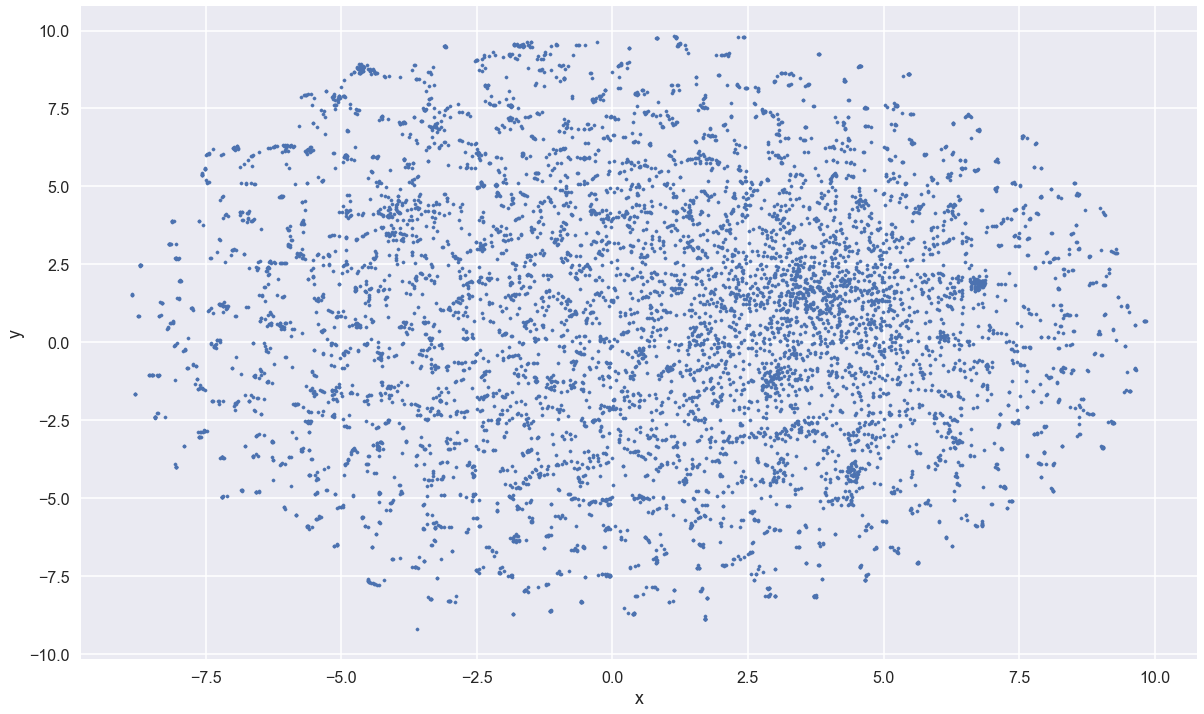

In [62]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

# Plot a particular area

In [63]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

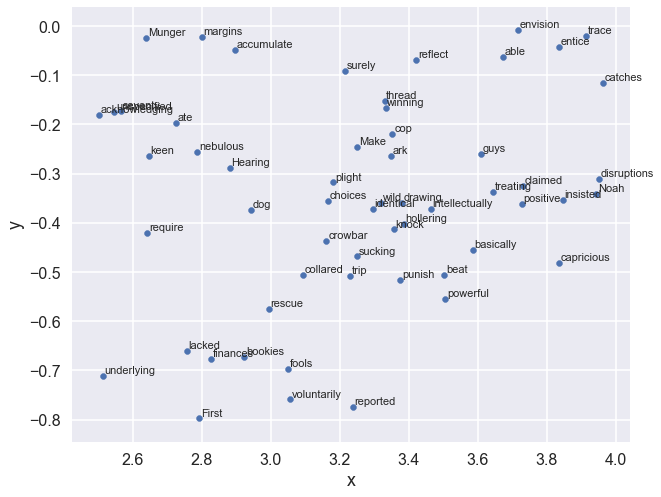

In [64]:
plot_region(x_bounds=(2.5, 4), y_bounds=(-0.8, 0))

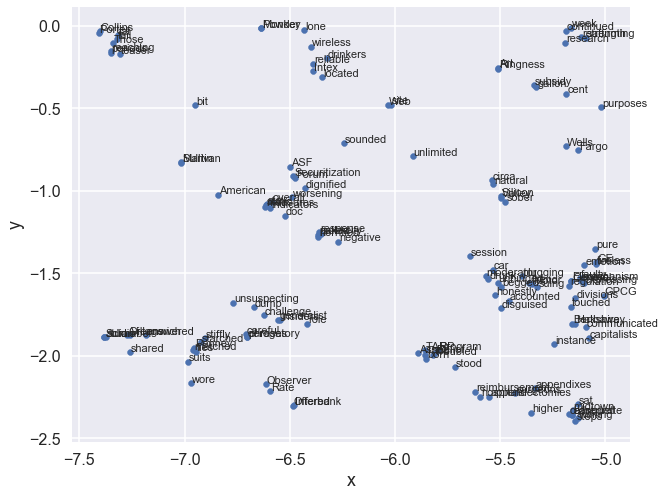

In [69]:
plot_region(x_bounds=(-7.5, -5), y_bounds=(-2.5, 0))

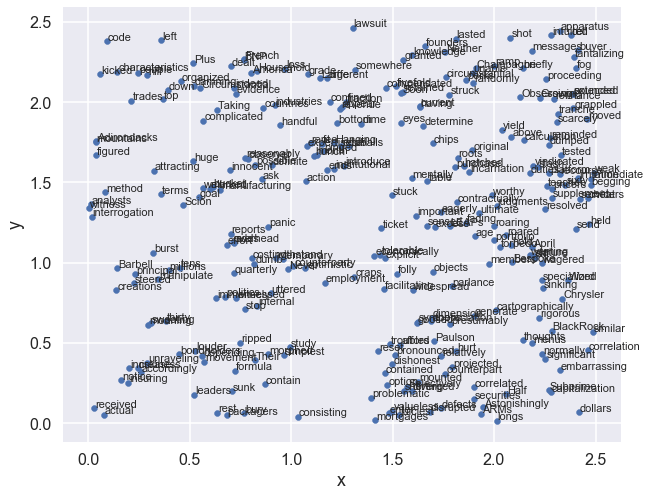

In [76]:
plot_region(x_bounds=(0, 2.5), y_bounds=(0, 2.5))

# Words closest to the given word

In [42]:
tbs2vec.most_similar("fraud")

[(u'perpetrated', 0.49372661113739014),
 (u'blatant', 0.4781036376953125),
 (u'fivefold', 0.4672967493534088),
 (u'se', 0.4584176540374756),
 (u'widespread', 0.44346895813941956),
 (u'punish', 0.4406236410140991),
 (u'vintage', 0.4313380718231201),
 (u'integral', 0.4282061457633972),
 (u'scam', 0.42154431343078613),
 (u'oblivious', 0.41629570722579956)]

# Linear relationships between word pairs

In [44]:
#distance, similarity, and ranking
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = tbs2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

man to woman, doctor to nurse 

In [59]:
nearest_similarity_cosmul("fools", "lacked", "powerful")

fools is related to lacked, as Atlantic is related to powerful


u'Atlantic'

In [86]:
nearest_similarity_cosmul("action", "Chinese", "American")

action is related to Chinese, as settled is related to American


u'settled'

In [75]:
nearest_similarity_cosmul("careful", "positive", "negative")

careful is related to positive, as derogatory is related to negative


u'derogatory'

In [84]:
nearest_similarity_cosmul("lawsuit", "problematic", "panic")

lawsuit is related to problematic, as shouts is related to panic


u'shouts'